# Applying the Hidden Markov Model on Budget allocation

The hidden markov model would recommend a budget using conversion state transitions, budget emissions, and return on investment indicators 

### Objective
Minimize the budget _B<sub>t</sub>_ to transition from state _S<sub>t</sub>_ to _S<sub>t+1</sub>_

### Subject to
* Sum of _B<sub>t</sub>_ <= _B_;  for all _t_
* RMS of _R_ <= $\epsilon$; where _R_ is the Residual of the expected and actual return on investmenet _B_
* Sum of _S<sub>t+1</sub> - S<sub>t</sub>_ <= _T_; where _T_ is the total allowable time period to complete all transitions from S<sub>start</sub> to S<sub>final</sub>

#### Reference
[Analyzing Time Series Data with Markov Transition Matrices](https://medium.com/towards-data-science/time-series-data-markov-transition-matrices-7060771e362b)

In [1]:
'''
    WARNING CONTROL to display or ignore all warnings
'''
import warnings; warnings.simplefilter('ignore')     #switch betweeb 'default' and 'ignore'
import traceback

''' Set debug flag to view extended error messages; else set it to False to turn off debugging mode '''
debug = True


## Instantiate Classes

In [8]:
import os
import sys
import numpy as np
from pyspark.sql import functions as F
import tensorflow_probability as tfp
import tensorflow as tf

proj_dir = os.path.abspath(os.pardir)
sys.path.insert(1,proj_dir.split('mining/')[0])
from rezaware.modules.etl.loader import sparkRDBM as db
from rezaware.modules.etl.loader import sparkFile as file
# from rezaware.modules.etl.loader import __propAttr__ as attr

''' restart initiate classes '''
if debug:
    import importlib
    db = importlib.reload(db)
    file=importlib.reload(file)
    # attr=importlib.reload(attr)

__desc__ = "read and write BigQuery dataset for hypothese testing"
clsSDB = db.dataWorkLoads(
    desc=__desc__,
    db_type = 'bigquery',
    db_driver=None,
    db_hostIP=None,
    db_port = None,
    db_name = None,
    db_schema='combined_data_facebook_ads',
    spark_partitions=None,
    spark_format = 'bigquery',
    spark_save_mode=None,
    # spark_jar_dir = _jar,
)
clsFile = file.dataWorkLoads(
    desc = "optimizing action_type budgets for an ad",
    store_mode='local-fs',
    store_root=proj_dir.split('mining/')[0],
    jar_dir=None,
)
# if clsSDB.session:
#     clsSDB._session.stop
print("\n%s class initialization and load complete!" % __desc__)

2025-02-13 13:09:13.302701: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-13 13:09:15.249253: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-13 13:09:16.390989: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739423357.407988  318893 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739423357.614501  318893 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-13 13:09:19.496428: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

All functional SPARKRDBM-libraries in LOADER-package of ETL-module imported successfully!
All functional SPARKFILE-libraries in LOADER-package of ETL-module imported successfully!
__propAttr__ Class initialization complete
__propAttr__ Class initialization complete
sparkFile Class initialization complete

read and write BigQuery dataset for hypothese testing class initialization and load complete!


## Load data

In [3]:
options = {
    "inferSchema":True,
    "header":True,
    "delimiter":",",
    "pathGlobFilter":'*.csv',
    "recursiveFileLookup":True,
}

sdf=clsFile.read_files_to_dtype(
    as_type = "SPARK",      # optional - define the data type to return
    folder_path="mining/data/budget/",  # optional - relative path, w.r.t. self.storeRoot
        file_name="complete-60-accounts.csv",  # optional - name of the file to read
        file_type=None,  # optional - read all the files of same type
        **options,
)
print("Loaded %d rows" % sdf.count())
sdf.printSchema()

25/02/13 10:36:40 WARN Utils: Your hostname, Waidy-Think-Three resolves to a loopback address: 127.0.1.1; using 192.168.2.82 instead (on interface enp0s25)
25/02/13 10:36:40 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
25/02/13 10:36:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
                                                                                

Loaded 61513 rows
root
 |-- account_id: long (nullable = true)
 |-- ad_id: long (nullable = true)
 |-- adset_id: long (nullable = true)
 |-- campaign_id: long (nullable = true)
 |-- updated_time: date (nullable = true)
 |-- impressions: integer (nullable = true)
 |-- frequency: double (nullable = true)
 |-- reach: integer (nullable = true)
 |-- CTR: double (nullable = true)
 |-- CPC: double (nullable = true)
 |-- CPM: double (nullable = true)
 |-- ROAS: double (nullable = true)
 |-- social_spend: double (nullable = true)
 |-- spend: double (nullable = true)
 |-- click: integer (nullable = true)
 |-- auction_bid: integer (nullable = true)
 |-- goal: string (nullable = true)
 |-- purchase_value: double (nullable = true)
 |-- account_currency: string (nullable = true)
 |-- purchase: double (nullable = true)
 |-- fb_pixel_view_value: double (nullable = true)
 |-- fb_pixel_purchase_value: double (nullable = true)
 |-- fb_pixel_add_to_cart_value: double (nullable = true)
 |-- mobile_app_purc

## Filter data into Inputs and Outputs


In [15]:
    # 'spend','omni_view_content_value', 'omni_add_to_cart_value',
    # 'omni_initiated_checkout_value', 'omni_purchase_value').dropna().collect())

_data_df= sdf.select('spend','CTR', 'CPC', 'CPM', 'ROAS').dropna().toPandas()
print("data shape:", _data_df.shape)
print("data mean :", _data_df.mean())
print("data std  :", _data_df.std())

data shape: (26193, 5)
data mean : spend    972.451701
CTR        3.682901
CPC        5.260815
CPM      108.559637
ROAS       8.339972
dtype: float64
data std  : spend    1701.870868
CTR         3.735689
CPC         7.055442
CPM       113.554289
ROAS      269.040776
dtype: float64


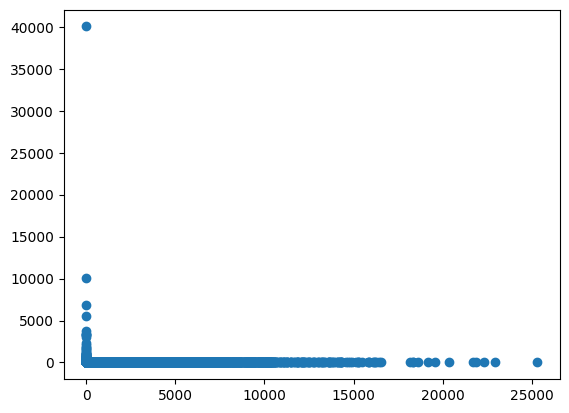

In [74]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(_data_df['spend'],_data_df['ROAS'])

## Define the model

* [Probabilistic Modeling with TensorFlow Probability](https://www.scaler.com/topics/tensorflow/tensorflow-probability/)
* [Tensorflow probability examples](https://github.com/tensorflow/probability/tree/main/tensorflow_probability/examples/jupyter_notebooks)

## Generate the data

In [98]:
# Compile and train the standard neural network
_pred_cols = ['CPC'] #, 'CPM', 'ROAS', 'CTR']
_label_col = ['spend']
X = np.array(_data_df[_pred_cols])
y = np.array(_data_df[_label_col])             
print("X: ",X.shape,"y: ", y.shape)

X:  (26193, 1) y:  (26193, 1)


In [99]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
print("X_train: ",X_train.shape, "y_train: ", y_train.shape,
      "\nX_test: ", X_test.shape, "y_test: ", y_test.shape)

X_train:  (20954, 1) y_train:  (20954, 1) 
X_test:  (5239, 1) y_test:  (5239, 1)


## Simple Linear Regression model

In [103]:
from sklearn.linear_model import LinearRegression
clf = LinearRegression()
clf.fit(X_train, y_train)

LinearRegression()

In [104]:
clf.predict(X_test)

array([[ 844.78468164],
       [ 855.85470529],
       [ 870.55488985],
       ...,
       [ 919.98200704],
       [ 881.8960878 ],
       [1091.09395199]])

In [105]:
clf.score(X_test, y_test)

0.01401655770280863

## Define probabilisti priors model parameters

In [23]:
# Define variables with priors
w = tfp.util.TransformedVariable(
    initial_value=tf.random.normal([]),
    bijector=tfp.bijectors.Exp(),
    name='w'
)
b = tfp.util.TransformedVariable(
    initial_value=tf.random.normal([]),
    bijector=tfp.bijectors.Identity(),
    name='b'
)
print("w: ", w, "\nb: ", b)

w:  <TransformedVariable: name=w, dtype=float32, shape=[], fn="exp", numpy=0.48268947> 
b:  <TransformedVariable: name=b, dtype=float32, shape=[], fn="identity", numpy=1.4808263>


## Define the Probabilistic Model

In [24]:
# Likelihood: Normal distribution
likelihood = tfp.distributions.Normal(loc=X * w + b, scale=1.0)

# Prior: Normal distribution
prior = tfp.distributions.Normal(loc=0.0, scale=1.0)


## Define Joint Log-Probability Function
This function is pivotal in Bayesian inference, aiding the estimation of posterior distributions for the parameters.

In [27]:
def joint_log_prob(w, b):
    return tf.reduce_sum(likelihood.log_prob(y)) + prior.log_prob(w) + prior.log_prob(b)


## Perform Inference
It generates num_samples samples after a num_burnin_steps burn-in period using the defined HMC kernel with specified leapfrog steps and step size. The resulting samples provide insights into the parameter distributions, crucial for understanding uncertainty in Bayesian modelling.

In [28]:
# Run Hamiltonian Monte Carlo
num_samples = 1000
num_burnin_steps = 500
hmc = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=joint_log_prob,
    num_leapfrog_steps=10,
    step_size=0.1
)
samples, _ = tfp.mcmc.sample_chain(
    num_results=num_samples,
    num_burnin_steps=num_burnin_steps,
    current_state=[w, b],
    kernel=hmc
    )

## Analyze Results:
Analyze the posterior samples to make predictions and infer uncertainty.

In [45]:
# Compute posterior means and standard deviations
w_posterior_mean = tf.math.reduce_mean(samples[0])
print('w posterior mean',w_posterior_mean.numpy())
b_posterior_mean = tf.math.reduce_mean(samples[1])
print('b posterior mean',b_posterior_mean.numpy())
w_posterior_stddev = tf.math.reduce_std(samples[0])
print('w posterior stdv',w_posterior_stddev.numpy())
b_posterior_stddev = tf.math.reduce_std(samples[1])
print('b posterior stdv',b_posterior_stddev.numpy())

# Make predictions
X_new = tf.constant([3.0, 1.0, 30.0, 5.0])
y_pred = X_new * w_posterior_mean + b_posterior_mean
print('Predicted y',y_pred.numpy())

w posterior mean 0.022246681
b posterior mean -0.6961578
w posterior stdv 1.3906807
b posterior stdv 1.6703713
Predicted y [-0.6294178  -0.67391115 -0.02875739 -0.5849244 ]


In [57]:
class DistributionLambdaLayer(Layer):
    def __init__(self, **kwargs):
        super(DistributionLambdaLayer, self).__init__(**kwargs)
        self.dist_lambda = tfp.layers.DistributionLambda(
            lambda t: tfp.distributions.Normal(loc=t, scale=1)
        )

    def call(self, inputs):
        # Get the distribution
        distribution = self.dist_lambda(inputs)
        # Return a tensor (e.g., the mean of the distribution)
        return distribution.mean()

In [60]:
X.shape

(26193, 4)

In [62]:
# Build model.
import tensorflow as tf
# import tf_keras
import tensorflow_probability as tfp
tfd = tfp.distributions

model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(26193, 4)),
  # tfp.layers.DistributionLambda(
  #     make_distribution_fn=lambda t: tfd.Normal(loc=t, scale=1)),
    DistributionLambdaLayer()
])

# Do inference.
negloglik = lambda y, p_y: -p_y.log_prob(y)
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.05), 
              loss=negloglik)
model.fit(X, y, epochs=500, verbose=False)

# Make predictions.
# yhat = model(x_tst)

ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(None, 4), dtype=float32). Expected shape (None, 26193, 4), but input has incompatible shape (None, 4)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 4), dtype=float32)
  • training=True
  • mask=None

In [8]:
# Build a simple feedforward neural network using Keras layers
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(4,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
])
model.summary()

2025-02-12 05:49:04.783398: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-12 05:49:06.704918: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-12 05:49:08.071677: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739310549.122035  165103 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739310549.320128  165103 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-12 05:49:11.067637: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,961 (35.00 KB)

 Trainable params: 8,961 (35.00 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X, y, epochs=50, batch_size=32, validation_split=0.2)

(26193, 1)
(26193, 4)
Epoch 1/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 3626547.7500 - val_loss: 1518566.8750
Epoch 2/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 3411655.5000 - val_loss: 1674311.5000
Epoch 3/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2960561.0000 - val_loss: 1804844.5000
Epoch 4/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 3093631.5000 - val_loss: 1755343.3750
Epoch 5/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2926415.7500 - val_loss: 1768326.8750
Epoch 6/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2796003.2500 - val_loss: 1701031.5000
Epoch 7/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2892816.2500 - val_loss: 1772219.5000
Epoch 8/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2850141.5000 - val_loss: 1727818.5000
Epoch 9/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2855108.5000 - val_loss: 1694924.8750
Epoch 10/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2670453.7500 - val_loss: 1651321.12

In [107]:
import tensorflow_probability as tfp
import tensorflow as tf

# tfd = tfp.distributions

# Create a normal distribution with mean 0 and standard deviation 1
normal_dist = tfp.distributions.MultivariateNormalDiag(
    loc=list(np.mean(_inputs,axis=0)), scale_diag=list(np.std(_inputs,axis=0)))

# Sample 10 values from the distribution
samples = normal_dist.sample(1000)
print(samples)

pdf = normal_dist.prob([111.85, 3.141218, 0.972609, 30.551762, 2.24693786])
print(pdf)

tf.Tensor(
[[ 2.49643744e+03 -7.88446263e-01  1.71886128e+01  2.15684666e+02
  -4.87337512e+02]
 [ 2.01140934e+03 -1.95461483e+00  1.84851381e+00  2.43528923e+01
   2.91290725e+02]
 [ 1.63743996e+03  4.74646288e+00  4.12711029e+00  1.60024312e+02
  -9.49096400e+01]
 ...
 [ 5.76136509e+02  6.74416321e-01  3.23089529e+00  1.09023232e+01
  -4.26150400e+02]
 [-1.20320048e+03  3.98268872e+00  1.91826767e-01  3.30172761e+02
   2.21872526e+02]
 [ 2.47465358e+03  4.31270382e+00 -7.15948113e-01 -1.10345032e+02
  -1.75742185e+02]], shape=(1000, 5), dtype=float64)
tf.Tensor(4.215444140563353e-12, shape=(), dtype=float64)


In [109]:
# Create a bijector (example: Sigmoid)
sigmoid_bijector = tfp.bijectors.Sigmoid()

# Apply the bijector to a sample
x = tf.constant([-1.0, 0.0, 1.0])
y = sigmoid_bijector.forward(x)
print(x,y)

tf.Tensor([-1.  0.  1.], shape=(3,), dtype=float32) tf.Tensor([0.26894143 0.5        0.7310586 ], shape=(3,), dtype=float32)
